# Behavioral Gestures

Laban/Bartenieff Movement Analysis (LMA) characterizes gestures as individual movements that convey meaning. Within LMA, behavioral gestures can be seen as functional, everyday, or task-oriented movements. In this notebook, we will employ analytic and geometric methods to devise a rule-based system for identifying common behavioral gestures from extracted features. Since no existing model specifically addresses this task, we will begin with basic behavioral gestures such as *standing* and *balancing on one foot*.

### Required Modules

In [102]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2

In [103]:
kd = pd.read_csv('./data/interim/contemporary_001/landmarks_rel.csv')
kd.head(3)

,frame,fps,nose_x,nose_y,nose_z,left_eye_inner_x,left_eye_inner_y,left_eye_inner_z,left_eye_x,left_eye_y,...,left_heel_z,right_heel_x,right_heel_y,right_heel_z,left_foot_index_x,left_foot_index_y,left_foot_index_z,right_foot_index_x,right_foot_index_y,right_foot_index_z
0,0,30.0,0.501249,0.210489,-0.084651,0.508947,0.194841,-0.062590,0.514194,0.195405,...,0.194230,0.486190,1.043211,0.169051,0.553575,1.095078,0.094697,0.472769,1.089564,0.054567
1,1,30.0,0.501941,0.211275,-0.245253,0.509505,0.196352,-0.219250,0.514590,0.196742,...,0.237259,0.480995,1.046322,0.222537,0.560630,1.103797,0.113512,0.466166,1.095931,0.094065
2,2,30.0,0.502662,0.211565,-0.249403,0.510098,0.196954,-0.222894,0.515015,0.197282,...,0.243565,0.478280,1.051128,0.219385,0.563342,1.108813,0.119277,0.463451,1.101899,0.090151


## Gesture Detection through Similar Joint Coordinates

This proposed solution uses static images or landmarks to create rules for detecting similar poses. The function, count_similar_frames(), takes in a reference DataFrame containing the criteria values for a desired pose, and an input DataFrame containing pose data. By comparing the input pose data to the reference criteria within a specified tolerance, the function calculates the duration of time in seconds for which the input pose is similar to the desired pose. This approach can be useful in applications such as motion tracking and motion analysis, where it is important to identify similar poses over time.

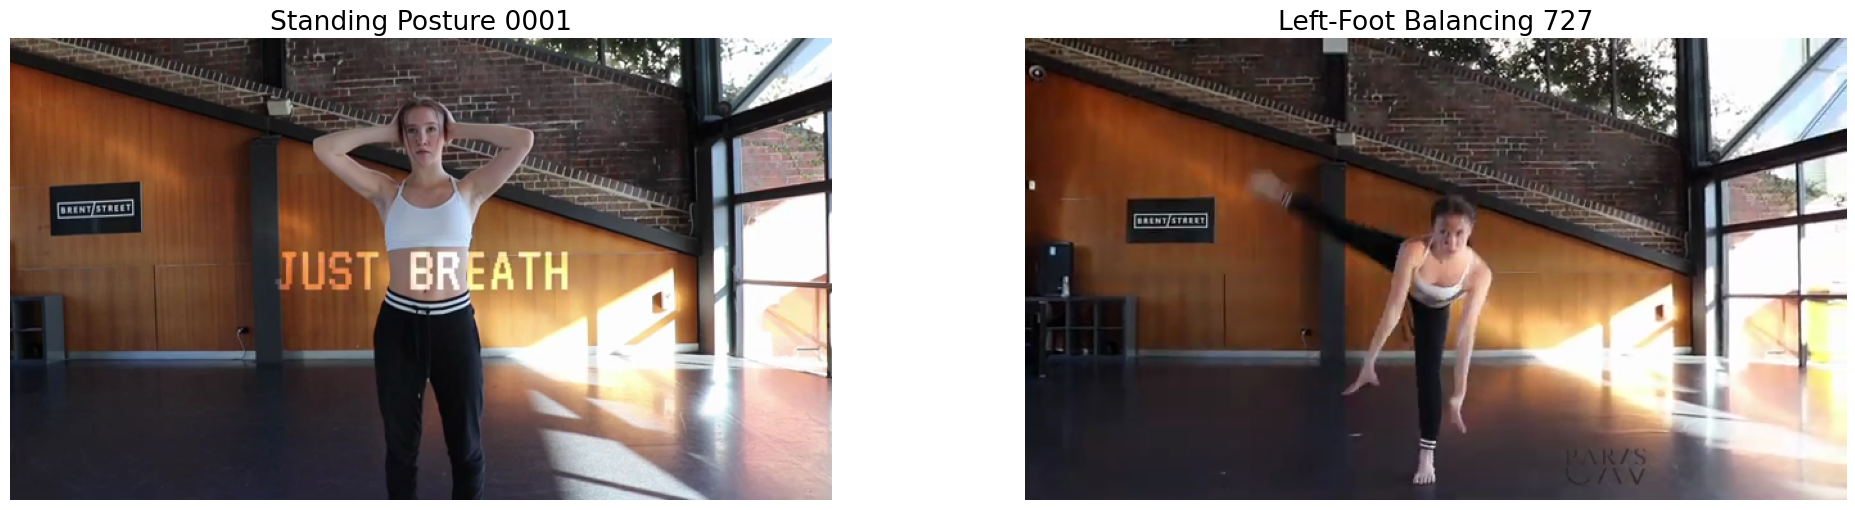

In [104]:
plt.rcParams.update({'font.size': 16})

fig, axs = plt.subplots(1, 2, figsize=(24, 6))
img1 = cv2.imread('./data/interim/contemporary_001/frames_o/00002.png')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
axs[0].set_title('Standing Posture 0001')
axs[0].imshow(img1)
axs[0].axis('off')

img2 = cv2.imread('./data/interim/contemporary_001/frames_o/00727.png')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
axs[1].set_title('Left-Foot Balancing 727')
axs[1].imshow(img2)
axs[1].axis('off')

plt.show()

Here we define the important joints to detect a behavioral gesture.

In [105]:
kd_input = pd.read_csv('./data/interim/contemporary_001/landmarks_rel.csv')

kd_ref_stand = kd[kd['frame'] == 2]
kd_ref_stand = kd_ref_stand[['right_hip_x','right_hip_y','right_hip_z',
                'right_knee_x','right_knee_y','right_knee_z',
                'left_hip_x','left_hip_y','left_hip_z',
                'left_knee_x','left_knee_y','left_knee_z']]
kd_ref_stand = kd_ref_stand.reset_index(drop=True)



kd_ref_left_balance = kd[kd['frame'] == 2]
kd_ref_left_balance = kd_ref_left_balance[['nose_x','nose_y','nose_z',
                'left_foot_index_x','left_foot_index_y','left_foot_index_z',
                'left_hip_x','left_hip_y','left_hip_z',
                'left_knee_x','left_knee_y','left_knee_z']]
kd_ref_left_balance = kd_ref_left_balance.reset_index(drop=True)

kd_ref_left_balance.head()


,nose_x,nose_y,nose_z,left_foot_index_x,left_foot_index_y,left_foot_index_z,left_hip_x,left_hip_y,left_hip_z,left_knee_x,left_knee_y,left_knee_z
0,0.502662,0.211565,-0.249403,0.563342,1.108813,0.119277,0.541689,0.62813,0.000883,0.555522,0.877846,-0.024074


In [106]:
def count_similar_frames(kd_ref, kd_input, fps, tolerance):
    criteria_labels = [col for col in kd_ref.columns]
    criteria_values = kd_ref.values.tolist()
    kd_input = kd_input.loc[:, criteria_labels]  
    diff = np.abs(kd_input.values - criteria_values)
    is_similar = (diff < tolerance).all(axis=1)
    similar_frames = np.count_nonzero(is_similar)
    duration = similar_frames / fps
    return duration

standing_duration = count_similar_frames(kd_ref_stand,kd_input,30,tolerance=0.1)
print(f"Detected standing position in {standing_duration}s")

standing_duration = count_similar_frames(kd_ref_left_balance,kd_input,30,tolerance=0.1)
print(f"Detected balancing position in {standing_duration}s")

Detected standing position in 7.4s
Detected balancing position in 4.4s


In [28]:
import mediapipe as mp

mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils 
mp_drawing_styles = mp.solutions.drawing_styles

def segment_image(image):
    with mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5, model_complexity=2, enable_segmentation=True) as pose:
        results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        annotated_image = image.copy()
        red_img = np.zeros_like(annotated_image, dtype=np.uint8)
        red_img[:, :] = (255,255,255)
        segm_2class = 0.2 + 0.8 * results.segmentation_mask
        segm_2class = np.repeat(segm_2class[..., np.newaxis], 3, axis=2)
        annotated_image = annotated_image * segm_2class + red_img * (1 - segm_2class)
        return annotated_image

def save_image(image, output_path):
    cv2.imwrite(output_path, image)
    
def display_pose_landmarks(image):
    with mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5, model_complexity=2) as pose:
        results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)

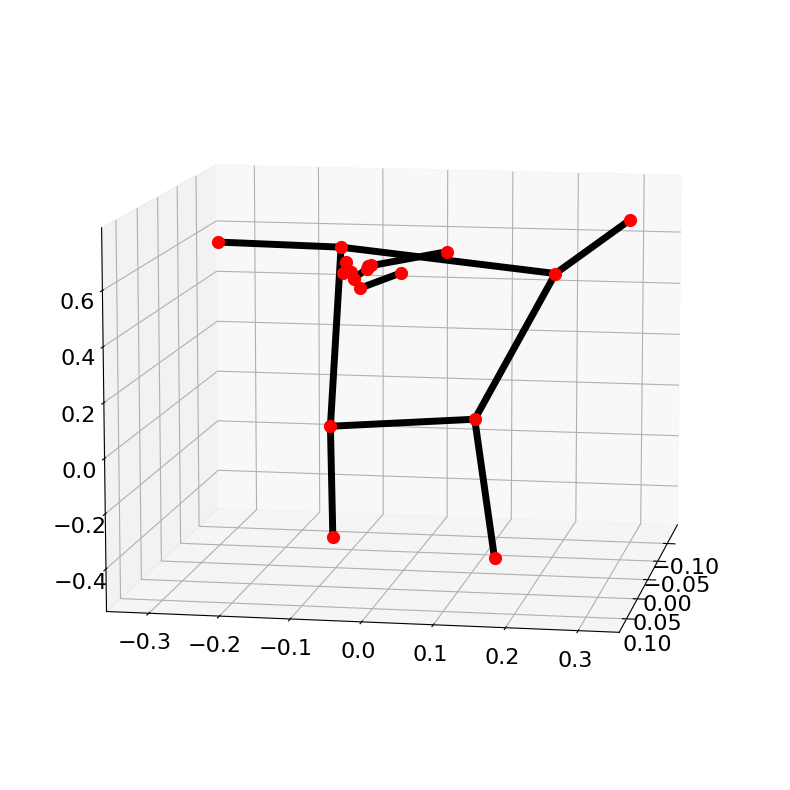

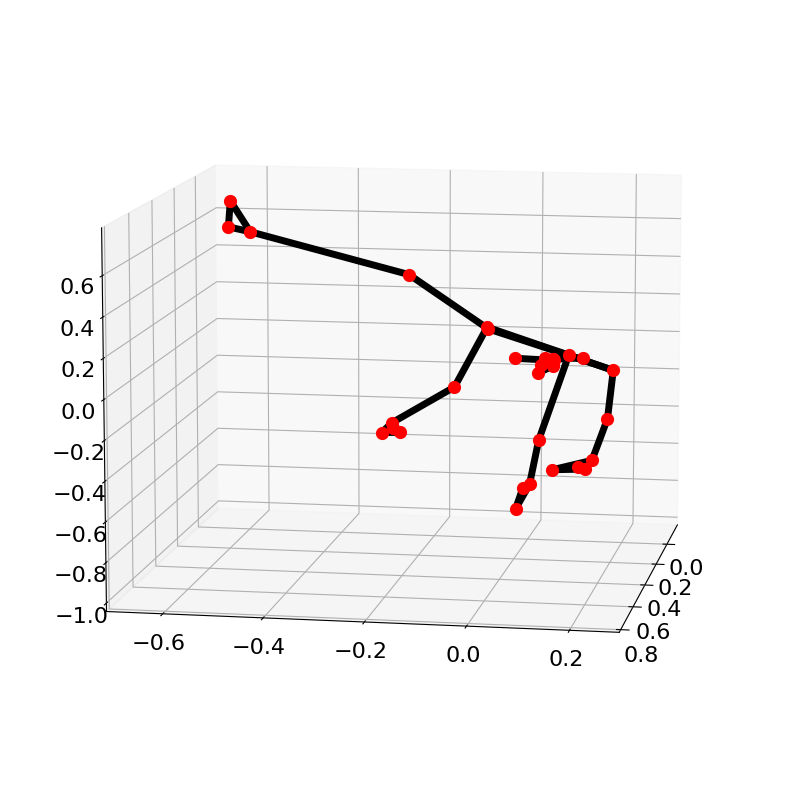

In [107]:
display_pose_landmarks(img1)
display_pose_landmarks(img2)

## Gesture Extraction through Image Segmentation

In [108]:
segmented_img = segment_image(img1)
save_image(segmented_img,'./data/processed/contemporary_001_00001.png')

segmented_img = segment_image(img2)
save_image(segmented_img,'./data/processed/contemporary_001_00727.png')

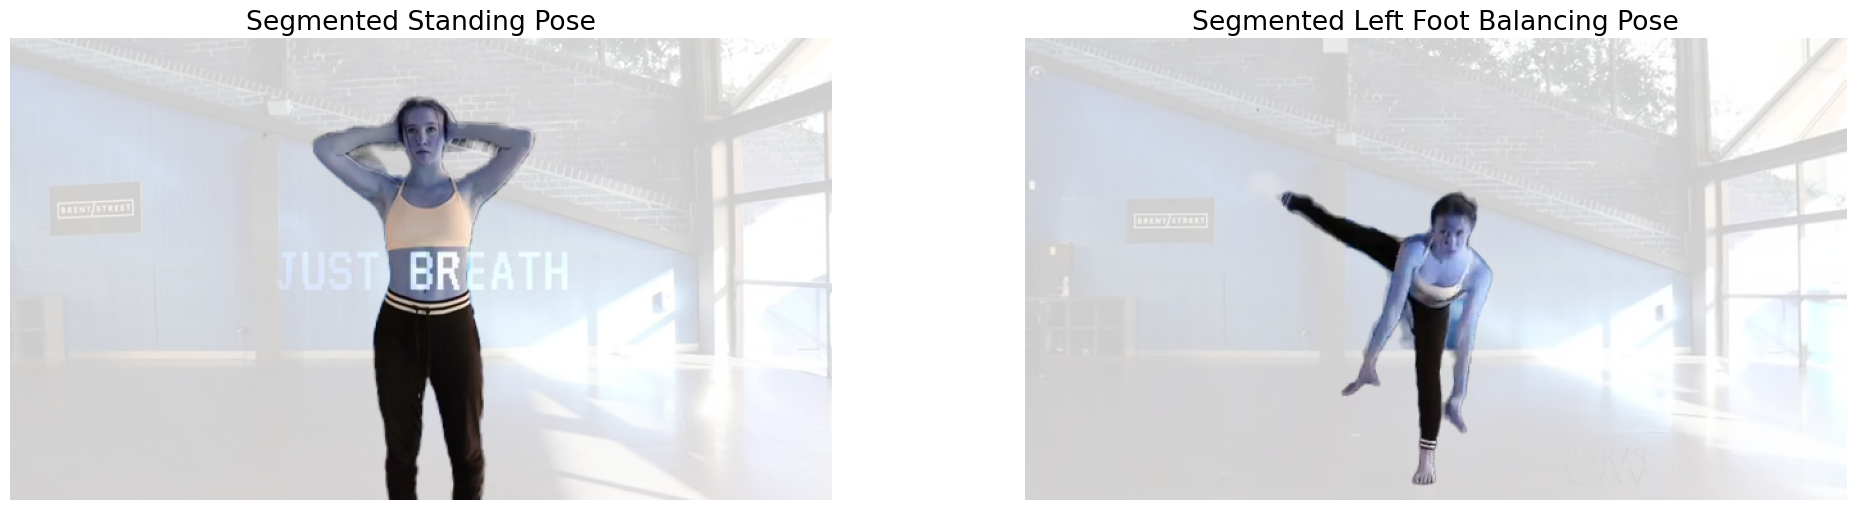

In [112]:
fig, axs = plt.subplots(1, 2, figsize=(24, 6))
img1 = cv2.imread('./data/processed/contemporary_001_00001.png')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
axs[0].set_title('Segmented Standing Pose')
axs[0].imshow(img1)
axs[0].axis('off')

img2 = cv2.imread('./data/processed/contemporary_001_00727.png')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
axs[1].set_title('Segmented Left Foot Balancing Pose')
axs[1].imshow(img2)
axs[1].axis('off')

plt.show()

## To be continued